# Implement HiTS-EQ in python - both Equation and curve fitting solutions
Hsuan-Chun Lin 2023.03

In this version, multiple points are supported. You can use different number of concentrations without change any parameters in the sourcecode.
## Curve Fitting Solution - recommended
### Import necessary packages

In [1]:
import numpy as np
import pandas as pd
from scipy.optimize import curve_fit
from scipy import stats
from functools import partial
import seaborn as sns
import matplotlib.pylab as plt
import plotly.express as px

### Import data in csv format and fetch the binding fractions

In [2]:
filename_input = "ESS3R_rp2.csv"
df = pd.read_csv(filename_input, header=0)
df.head()

,Seq,1,2,3,4
0,f,0,0.25,0.50,0.75
1,[E],0,1.25,3.75,11.25
2,AAAAAAA,14678,12483.00,12931.00,9406.00
3,AAAAAAC,9549,8434.00,9251.00,6802.00
4,AAAAAAG,6402,5014.00,4332.00,3063.00


## Set parameters
Set your reference row number. If your reference sequence locates at the 3rd row, please enter **2** because pyton starts from *0*.


In [18]:
ref_row_number = 2
k_initial = 1
count_threshold = 600

### Data format preprocessing

In [19]:
#Extract enzyme concentrations
enzyme_concentration =  df.iloc[1,1:]

#Calculate binding fractions (1-f)
binding_fraction = 1 - df.iloc[0,1:].astype(float)

#Extract sequence counts and reset index
sequence_count = df.iloc[2:,1:]
library = df.iloc[2:,0].reset_index().drop("index",axis=1)

In [20]:
#sequence_count.any((sequence_count < count_threshold))
def threshold_check(x):
    if x >= count_threshold:
        return "OK"
    else:
        return "NG"
qc = sequence_count.iloc[:,1].astype(float).apply(threshold_check).reset_index(drop=True).apply(pd.Series)

### Define fitting function
$$f = 1 -( \frac{D_{t}}{D_t1}\times (1-frac) \times \frac{D_1}{D_0})= \frac{E}{E+K_D}$$

In [6]:
#Calculate summation of sequence counts for each data point.
Dt_all = sequence_count.sum()
#Calculate Dt/Dt1
Dt_Dt1_all = Dt_all[0]/Dt_all
#Extract all the D0
D0_ = sequence_count.iloc[:,0]
#Calculate D1/D0
D1fD0 = sequence_count.divide(D0_,axis='rows')
#Create table for fitting
fitting_table = 1 - (Dt_Dt1_all * binding_fraction * D1fD0)
#Assign a very small random value for each value less than 0 in order to make sure the fitting can be performed well.
fitting_table[fitting_table < 0] = np.random.randint(1,9)/100000
#Reset the index of fitting table
fitting_table = fitting_table.reset_index()
fitting_table = fitting_table.drop("index",axis = 1)

### Define fitting equations and implement it by curve_fit and partial functions
Becuase we have calculated y, which is fitting table.
$$ y = 1 -( \frac{D_{t}}{D_t1}\times (1-frac) \times \frac{D_1}{D_0}) $$
Now we set a function
$$ y = \frac{x}{x+K} $$
Because our x will be the enzyme concentrations.

In [7]:
def HitsEQ(x, K):
    return x/(x+K)

def curvefit(func, x, y, k_initial):
    return tuple(curve_fit(func, x, y, p0=k_initial))

fit = partial(curvefit, HitsEQ, enzyme_concentration, k_initial=k_initial)
#Partial functions allow us to fix a certain number of arguments of a function and generate a new function.

### Fit your data and get results

In [21]:
#Fitting
K = fitting_table.apply(fit, axis=1).apply(pd.Series)

#Organize format
K.columns = ["K", "pcov"]
finalresult = K.explode(["K", "pcov"]).explode("pcov").reset_index(drop=True)
finalresult[["id"]] = library

#Convert Kd to Ka
finalresult[["KA"]] = (1/finalresult.K).apply(pd.Series)

#Calculate Ka to relative Ka
finalresult[["RKA"]] = (finalresult.KA/finalresult.KA[ref_row_number]).apply(pd.Series)
finalresult[["qc"]] = qc
#Rearrange the columns
cols = ['id', 'K', 'KA', 'RKA', 'pcov', 'qc']
finalresult = finalresult[cols]
#Make summary for pcov. You might use pcov to galance the fitting quality.
finalresult.pcov.astype(float).describe(percentiles=[.25, .5, .75],include=all)

count    16384.000000
mean         0.503295
std          2.306768
min          0.000017
25%          0.041713
50%          0.163404
75%          0.506285
max        240.359650
Name: pcov, dtype: float64

## Use pcov to filter the fitting result. pcov roughly means the error
pcov will contain the true variance and covariance of the parameters. Because we only have one parameter, the range of K is
$$ K \pm \sqrt{pcov} $$

In [63]:
limit_pcov = 10000000
filter = finalresult[(finalresult.pcov < limit_pcov)]
filter = filter[filter.qc=='OK']

### Visualize the fitting result by histogram

<AxesSubplot:xlabel='RKA', ylabel='Count'>

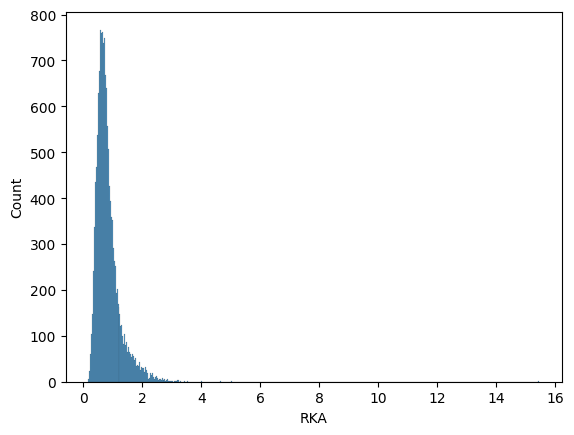

In [64]:
#Just plot rKa values
sns.histplot(filter.RKA)

<AxesSubplot:xlabel='RKA', ylabel='Count'>

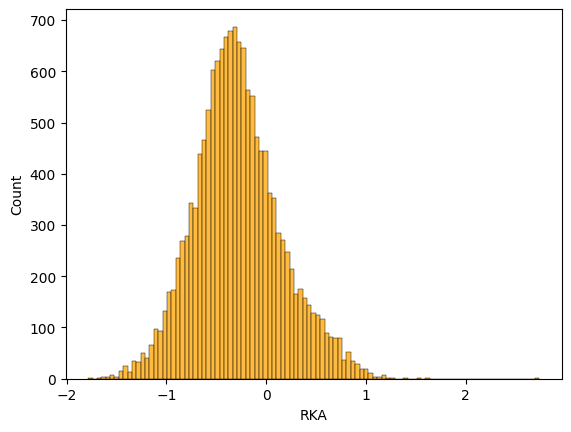

In [65]:
#Have nature log to indicate the gibbs energy
sns.histplot(np.log(filter.RKA.astype(float)), color = "orange")

## Equation solution - use unbound and one fraction point

$$ K_{2, rel} = \frac{E}{ \left( \frac{S_1}{S_2} \frac{S_{1,0}}{S_{2,0}}(1+E)\right)-1}$$

In [66]:
#Calculate S1/S2
S1 = sequence_count.iloc[2,:]
S10 = S1[0]
Step1 = 1/(sequence_count.divide(sequence_count.iloc[:,0], axis=0))
refs = S1/S1[0]
div_ = Step1 * refs * (1+enzyme_concentration) -1
rKd = enzyme_concentration/div_
RKA = 1/rKd
RKA = RKA.apply(pd.Series).reset_index(drop=True)
RKA["id"] = library
RKA["qc"] = qc

## Compare the results from fitting method and the equation method
I highly recommend to use both methods to calculate your result. Maybe we can find some hidden messages from both method. They might be from RNA structures, abnormal amplification, etc.

In [71]:
choose_col = 8
plotdata = filter.merge(RKA, on="id", how='left')
plotdata.head()

,id,K,KA,RKA,pcov,qc_x,1,2,3,4,qc_y
0,AAAAAAA,4.350185,0.229875,0.668422,0.104856,OK,NaN,0.857636,0.706237,0.724085,OK
1,AAAAAAC,5.211215,0.191894,0.557981,0.138084,OK,NaN,0.79612,0.61805,0.642479,OK
2,AAAAAAG,2.907761,0.343907,1.000000,0.100246,OK,NaN,1.0,1.0,1.0,OK
3,AAAAAAT,5.491894,0.182087,0.529464,0.918493,OK,NaN,0.677652,0.629373,0.659444,OK
4,AAAAACA,3.544758,0.282107,0.820299,0.189206,OK,NaN,0.92969,0.884113,0.750041,OK


/Users/fatmimi/.pyenv/versions/3.8.7/envs/mactf-sandbox/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning:

Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.



Text(0.5, 11.663096153588594, 'R-squared: 0.89')

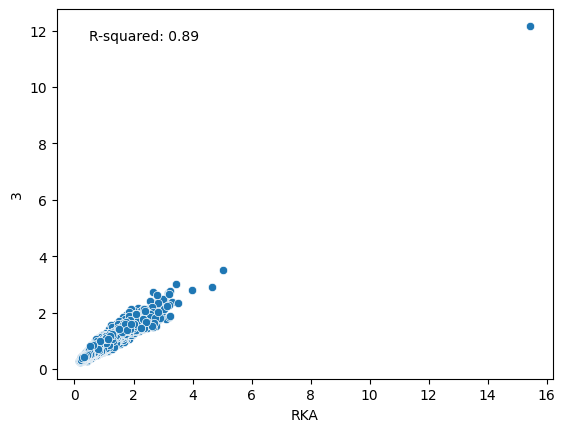

In [72]:
res = stats.linregress(plotdata.RKA.astype(float), plotdata.iloc[:,choose_col].astype(float))
sns.scatterplot(plotdata.RKA, plotdata.iloc[:,choose_col])
plt.text(0.5, plotdata.iloc[:,choose_col].max()-0.5, f"R-squared: {res.rvalue**2:.2f}", horizontalalignment='left', size='medium', color='black')


/Users/fatmimi/.pyenv/versions/3.8.7/envs/mactf-sandbox/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning:

Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.



Text(-2, 1.998406462022185, 'R-squared: 0.87')

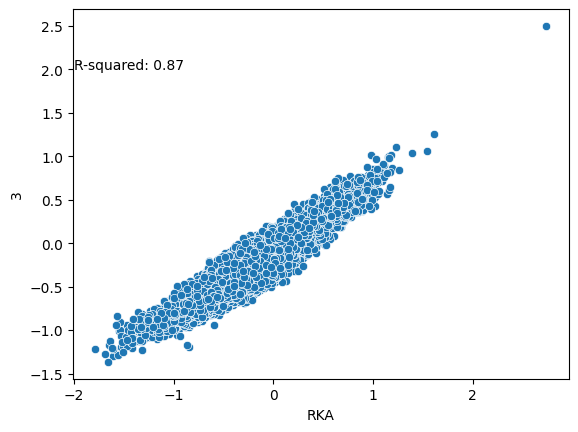

In [73]:
res_log = stats.linregress(np.log(plotdata.RKA.astype(float)),np.log(plotdata.iloc[:,choose_col].astype(float)))
sns.scatterplot(np.log(plotdata.RKA.astype(float)),np.log(plotdata.iloc[:,choose_col].astype(float)))
plt.text(-2, np.log(plotdata.iloc[:,choose_col].astype(float)).max()-0.5, f"R-squared: {res_log.rvalue**2:.2f}", horizontalalignment='left', size='medium', color='black')

### Interation Plot

In [74]:
fig = px.scatter(plotdata, x='RKA', y='3', color='qc_x', custom_data=['id','RKA'])
                    
#set hover
fig.update_traces(
    hovertemplate = "<br>".join([
    "Sequence: %{customdata[0]}",
    "RKA: %{customdata[1]}"])
)
fig.show()